# Chapter 10. Introduction to Artificial Neural Networks with Keras

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell

np.random.seed(0)

plt.style.use('seaborn-whitegrid')

In [2]:
%matplotlib inline

In [3]:
%load_ext ipycache

/opt/anaconda3/envs/daysOfCode-env/lib/python3.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/opt/anaconda3/envs/daysOfCode-env/lib/python3.7/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


## From biological to artificial neurons

The author briefly described the origins of the field of artificial neural networks (ANN) and how real neurons work; I will skip recounting that section here.

### Logical computations with neurons

The first artificial neuron was proposed as a function with one or more binary inputs and one binary output.
The output is activated when a certain number of inputs are activated.
Several of these neurons working together can reproduce standard logic gates.

### The Perceptron

The *perceptron* was invented in 1957 by Frank Rosenblatt.
It is *threshold logic unit* (TLU) (or a *linear threshold unit*, LTU).
Each input and the  output are numeric values (not binary) and each input has an associated weight.
The TLU computes the weighted sum of the inputs ($z = w_1 x_1 + w_2 x_2 + ... + w_n x_n = \textbf{x}^T \textbf{w}$) and applies a step function to the result to decide the output ($h_w(\textbf{x}) = \text{step}(z)$).
The most common step functions were the *Heaviside step function* and the *sign function*:

$$
\text{heaviside} (z) =
\begin{cases}
    0 \text{ if } z  <  0 \\ 
    1 \text{ if } z \ge 0 \\
\end{cases}
$$

$$
\text{sgn}(z) =
\begin{cases}
    -1 \text{if } z < 0 \\ 
    0  \text{if } z = 0 \\
    1  \text{if } z > 0 \\
\end{cases}
$$

A single TLU can be used for linear classification.
Training the TLU means finding the values for the weights ($w_1, w_2, ..., w_n = \textbf{w}$)

A perceptron is a single layer of TLUs with each TLU connected to all of the input neurons (creating a *fully connected layer*).
The input neurons are just simple passthrough functions where the output equals the input.
An extra *bias neuron* is usually added that always has the value 1 and is connected to each neuron; this helps with the linear algebra for calculating the output of the perceptron:

$$
h_{\textbf{W}, \textbf{b}} = \phi(\textbf{XW} + \textbf{b}) \\
$$

$$
\text{where }
\begin{cases}
    \textbf{X}: \text{represents the matrix of input features; one row per instance, one column per feature} \\
    \textbf{W}: \text{represents the weight matrix from the input neurons to the TLU neurons} \\
    \textbf{b}: \text{represents the weight vector from the bias neurons to the TLU neurons} \\
    \phi: \text{represents the activation function; the step function for TLUs} \\
\end{cases}
$$

The perceptron is trained using *Hebb's Rule*: the connection weight between two neurons tends to increase when they fire simultaneously.
The algorithm also accounts for the accuracy of the prediction; for each training instance, the weights are updated with the following *Perceptron learning rule*:

$$
w_{i,j}^{\text{next step}} = w_{i,j} + \eta (y_j - \hat{y_j}) x_i
$$

$$
\text{where }
\begin{cases}
    w_{i,j}: \text{the connection weight between the } i^{th} \text{ input neuron and } j^{th} \text{output neuron} \\
    x_i: \text{the } i^{th} \text{ input value of the training instance} \\
    \hat{y_j}: \text{the output of the } j^{th} \text{ output neuron for the training instance} \\
    y_j: \text{the target output of the } j^{th} \text{ output neuron for the training instance} \\
    \eta: \text{the learning rate} \\
\end{cases}
$$

The decision boundary for each output neuron is linear, so perceptrons are only capable of linear separation.
Though, when this is possible for the data, the perceptron will converge.

There are some critical limitations to a perceptron, notably that it cannot learn XOR logic, but many of these can be overcome by using multiple layers to create a *Multilayer Perceptron* (MLP).

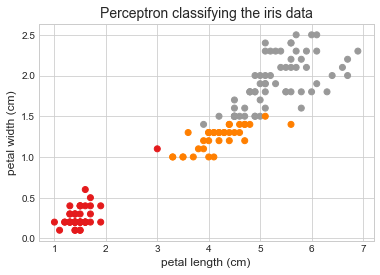

In [4]:
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

# Load the iris data and only use petal length and width (cm.).
iris = load_iris()
X = iris.data[:, (2, 3)]
y = iris.target

# Train a perceptron.
per_clf = Perceptron()
per_clf.fit(X, y)

# Plot the prediction results.
plt.scatter(X[:, 0], X[:, 1], c=per_clf.predict(X), cmap='Set1')
plt.title('Perceptron classifying the iris data', fontsize=14)
plt.xlabel(iris.feature_names[2], fontsize=12)
plt.ylabel(iris.feature_names[3], fontsize=12)
plt.show()

## The multilayer perceptron (MLP) and backpropagation

An MLP has one *input layer* built of passthrough neurons, one or more *hidden layers* of TLUs, and one *ouput layer* of TLUs. 
The layers near the input are called *lower layers* whereas the layers near the output are *upper layers*.
When an ANN contains a deep stack of hidden layers, it is called a *deep neural network* (DNN).

*Backpropagation* makes training a MLP possible.
It is able to compute the gradient of the nwtwork's error with regard to every single model parameter.
Therefore, the connection weights and bias terms can be tweaked optimally to reduce error.
Once the gradient is found, normal gradient descent can be followed.
Below is the most basic interpretation of the algorithm:

1. A mini-batch is fed into the input layers.
2. The data progresses through the layers and the results of each layer are remembered. This is the *forward pass*.
3. A final output is calculated and a loss function is used to determine the error.
4. The chain rule is used to measure how much each output connected contributed to the error.
5. The error is *backpropagated* using the chain rule to measure how much of the error came from each connection in the network.
6. The error gradient is used to compute the optimal adjustments for each connection weight.

In order to compute the derivative of each neuron, the step function had to be replaced.
Currently, it is common to use the logistic equation, hyperbolic tangent function, or rectified linear unit (ReLU):

$$
\begin{aligned}
\text{logistic: }& \quad \sigma(z) = 1 / (1 + e^{-z}) \\
\text{hyperbolic tangent: }& \quad \tanh(z) = 2 \sigma(2z) - 1 \\
\text{ReLU: }& \quad \text{ReLU}(z) = \max(0, z) \\
\end{aligned}
$$

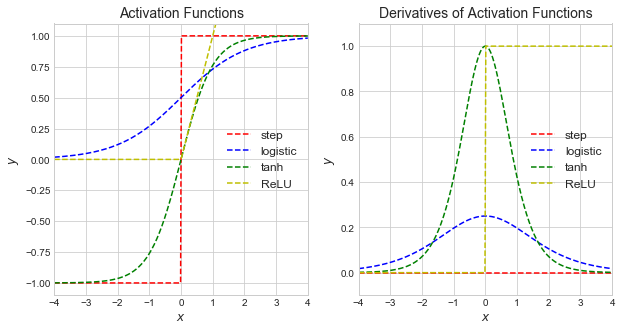

In [5]:
# Input points
x = np.linspace(-4, 4, 300)

# Neruon activation functions.

def step_fxn(x):
    """Step function for neuron activation function."""
    return [-1 if i < 0 else 1 for i in x]


def step_fxn_d(x):
    """Derivative of the step function."""
    return np.zeros(len(x))


def logistic_fxn(x):
    """Logisitc (sigmoid) function for neuron activation function."""
    return 1 / (1 + np.exp(-x))


def logistic_fxn_d(x):
    """The derivative of the logistic function."""
    return logistic_fxn(x) * (1 - logistic_fxn(x))


def hyperbolic_tan(x):
    """Hyperbolic tangent function for neuron activation function."""
    return 2 * logistic_fxn(2 * np.array(x)) - 1


def hyperbolic_tan_d(x):
    """The derivative of the hyperbolic tangent function."""
    return 1 - (np.tanh(x) ** 2)


def relu_fxn(x):
    """The ReLU for a neuron activation function."""
    return [max(0, i) for i in x]


def relu_fxn_d(x):
    """The derivative of the ReLU"""
    return [0 if i < 0 else 1 for i in x]


# Styles of line.
line_styles = {
    'step': 'r--',
    'logistic': 'b--',
    'tanh': 'g--',
    'relu': 'y--'
}

# Plotting each activation function.
fig = plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x, step_fxn(x), line_styles['step'], label='step')
plt.plot(x, logistic_fxn(x), line_styles['logistic'], label='logistic')
plt.plot(x, hyperbolic_tan(x), line_styles['tanh'], label='tanh')
plt.plot(x, relu_fxn(x), line_styles['relu'], label='ReLU')
plt.axis([-4, 4, -1.1, 1.1])
plt.legend(loc='center right', fontsize=12)
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$y$', fontsize=12)
plt.title('Activation Functions', fontsize=14)

# Plotting the derivatives of the activation function.
plt.subplot(1, 2, 2)
plt.plot(x, step_fxn_d(x), line_styles['step'], label='step')
plt.plot(x, logistic_fxn_d(x), line_styles['logistic'], label='logistic')
plt.plot(x, hyperbolic_tan_d(x), line_styles['tanh'], label='tanh')
plt.plot(x, relu_fxn_d(x), line_styles['relu'], label='ReLU')
plt.axis([-4, 4, -0.1, 1.1])
plt.legend(loc='center right', fontsize=12)
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$y$', fontsize=12)
plt.title('Derivatives of Activation Functions', fontsize=14)

plt.show()

### Regression MLP

For a regression MLP, there must be one output neuron per output variable.
The neuron's activation function must be chosen depending on any constraints on the output (e.g. always positive, between 0 and 1) and no activation function can be used to leave the output value unconstrained.
The loss function most  commonly used in the MSE, though the mean absolute error (MAE) or Huber loss (a mixture of MSE and MAE) can be used if the training data has a lot of outliers.

### Classification MLP

If the decision is a binary classification, then only one neuron is required with a logistic activation function.
If there are multiple decisions, but each is binary, then there must be a neuron per decision, each with a logistic activation function.
If there is a single decision, but multiple possibilities (i.e. the image of 1 of 10 digits), then there must be an output neuron for each option with a *softmax function* across the whole output layer.
The softmax function ensures that each neuron is between 0 and 1 (inclusive) and that they sum to 1.
The loss function is usually the cross-entropy loss function.

---

>**Before moving on to using Keras to build ANNs, I followed the advice of the author and skipped to Exercise 1 for the chapter which was to experiment in the [TensorFlow Playground](https://playground.tensorflow.org/).**

---

## Implementing MLPs with Keras



In [6]:
import tensorflow as tf
from tensorflow import keras

tf.__version__

'2.0.0'

In [7]:
keras.__version__

'2.2.4-tf'

### Building an image classifier using the sequential API

For the first example, we will build an image classifier of the MNIST Fashion data set.
It contains 70,000 28x28 grayscale images of clothing of 10 classes.

Keras provides some functions for accessing commonly used data.

In [8]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

Each image is a 28x28 array.

In [9]:
X_train_full.shape

(60000, 28, 28)

Each data point is an integer between 0 and 255.

In [10]:
X_train_full.dtype

dtype('uint8')

We need to make a validation set from the training data and scale the data to between 0 and 1.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin


# Split the training data into training and validation.
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full,
                                                      y_train_full,
                                                      test_size=5000,
                                                      random_state=0)


class FashionImageFlatten(BaseEstimator, TransformerMixin):
    """Flatten the 28x28 MNIST Fashion image."""

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.reshape(len(X), 28*28)


class FashionImageReshape(BaseEstimator, TransformerMixin):
    """Reshape the 28x28 MNIST Fashion image."""

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.reshape(len(X), 28, 28)


# A pipeline for pre-processing the MNIST Fashion data.
fashion_preprocesser = Pipeline([
    ('flattener', FashionImageFlatten()),
    ('minmax_scaler', MinMaxScaler()),
    ('reshaper', FashionImageReshape())
])
fashion_preprocesser.fit(X_train)

X_train = fashion_preprocesser.transform(X_train)
X_valid = fashion_preprocesser.transform(X_valid)

The names of the classes was not provided, so I had to enter them manually.
I found the known values in the [Keras documentation](https://keras.io/datasets/#fashion-mnist-database-of-fashion-articles).

In [12]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", 
               "Shirt", "Sneaker", "Bag", "Ankle boot"]

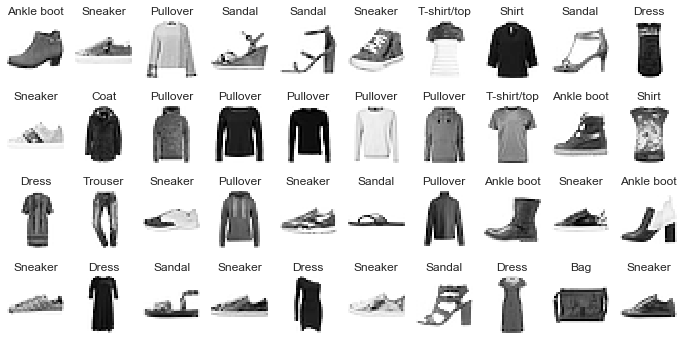

In [13]:
fig = plt.figure(figsize=(12, 6))
for i in range(40):
    plt.subplot(4, 10, i+1)
    plt.imshow(X_train[i, :, :])
    plt.title(class_names[y_train[i]])
    plt.axis('off')

plt.show()

The sequential API is used below to create the first neural network with two hidden layers.

In [14]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation='relu', name='dense_1'))
model.add(keras.layers.Dense(100, activation='relu', name='dense_2'))
model.add(keras.layers.Dense(10, activation='softmax', name='dense_3'))

Here is an explanation of each line:

1. A sequential model is initialized. It is just a single stack of layers connected sequentially.
2. The first layer is the input nodes that just flattens the 28x28 image into a single array. Since it is the first layer, the shape of the input must be explicitly stated.
3. The first hidden layer is a dense network of 300 neurons each with a ReLU activation function.
4. The second hidden layer is a dense network of 100 neurons each with a ReLU activation function.
5. The output layer is a dense network of 10 neurons using a softmax activation function.

Alternatively, the model could have been declared directly when initializing the Sequential model by passing a list of the layers.
The model can be inspected with the `summary()` method.

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


The list of layers can be accessed and specifically indexed by name.

In [16]:
model.layers

In [17]:
model.get_layer('dense_1')

In [18]:
weights, biases = model.get_layer('dense_1').get_weights()

In [19]:
weights

array([[ 4.4014677e-03, -4.7703154e-02, -5.6954548e-02, ...,
         1.3799518e-02,  6.8606809e-02,  4.4642702e-02],
       [ 1.1618771e-02,  6.5349728e-02, -1.9043323e-02, ...,
        -6.2322959e-02, -3.4375217e-02, -6.4794019e-02],
       [ 4.7343969e-04, -2.6652794e-02,  5.7301193e-02, ...,
        -7.3247261e-02,  3.8669445e-02,  6.1915472e-02],
       ...,
       [ 2.1660134e-02, -3.2525033e-02, -2.2409968e-02, ...,
        -1.6713545e-02, -4.5746118e-02, -3.6396444e-02],
       [ 2.5894038e-02,  4.4876792e-02, -3.1769171e-02, ...,
        -6.1228871e-05,  2.0354383e-02, -1.6598497e-02],
       [ 3.8472585e-02,  5.4374188e-02,  7.2529078e-02, ...,
        -4.8064545e-02,  3.8844623e-02, -2.2803590e-02]], dtype=float32)

In [20]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

Once the model's structure is created, it must be compiled.
This is when the loss function, optimizer, and any other metrics to be calculated during training and evaluation are added to the model.
There are additional parameters that we will learn about and opt to set in the future for increased performance.

In [21]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

Now the model is ready to be trained using the `fit()` method.

In [22]:
history = model.fit(X_train, y_train, 
                    epochs=30,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 26s 475us/sample - loss: 0.7192 - accuracy: 0.7617 - val_loss: 0.5081 - val_accuracy: 0.8246
Epoch 2/30
55000/55000 [==============================] - 9s 159us/sample - loss: 0.4897 - accuracy: 0.8295 - val_loss: 0.4663 - val_accuracy: 0.8366
Epoch 3/30
55000/55000 [==============================] - 8s 149us/sample - loss: 0.4448 - accuracy: 0.8448 - val_loss: 0.4331 - val_accuracy: 0.8514
Epoch 4/30
55000/55000 [==============================] - 8s 145us/sample - loss: 0.4185 - accuracy: 0.8535 - val_loss: 0.4125 - val_accuracy: 0.8560
Epoch 5/30
55000/55000 [==============================] - 8s 145us/sample - loss: 0.3976 - accuracy: 0.8608 - val_loss: 0.3831 - val_accuracy: 0.8666
Epoch 6/30
55000/55000 [==============================] - 8s 144us/sample - loss: 0.3837 - accuracy: 0.8657 - val_loss: 0.3930 - val_accuracy: 0.8628
Epoch 7/30
55000/55000 [==========================

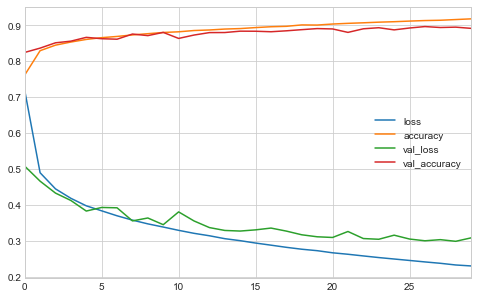

In [23]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

After tuning the hyperparamters (discussed later) and once we are satisfied with the models performance on the training data, we can evaluate its accuracy on the test data.

In [24]:
X_test_processed = fashion_preprocesser.transform(X_test)
model.evaluate(X_test_processed, y_test, verbose=0)

[0.33497632868289945, 0.8802]

We can also use the model to make predictions.
Using the `predict()` method, we get a probability per class.

In [25]:
X_new = fashion_preprocesser.transform(X_test[:3])
np.round(model.predict(X_new), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.01, 0.  , 0.95],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

The `predict_class()` method returns the class with the highest probability.

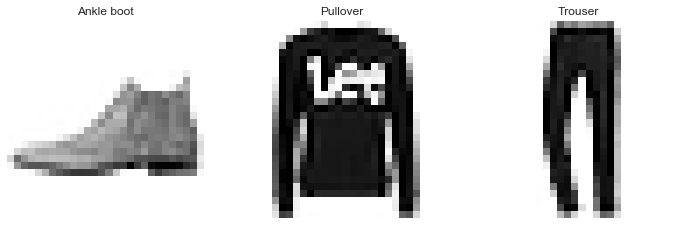

In [26]:
y_pred = model.predict_classes(X_new)

fig = plt.figure(figsize=(12, 6))
for i in range(len(X_new)):
    plt.subplot(1, 3, i+1)
    plt.imshow(X_new[i, :, :])
    plt.title(class_names[y_pred[i]])
    plt.axis('off')

plt.show()

### Building a regression MLP using the sequential API

We will build a regression ANN to predict housing prices in CA.

In [27]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, 
                                                              housing.target, 
                                                              random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, 
                                                      y_train_full, 
                                                      random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [28]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape = X_train.shape[1:]),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(1, activation='relu')
])

model.compile(loss='mean_squared_error', optimizer='sgd')

history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 2s 141us/sample - loss: 0.7797 - val_loss: 0.5026
Epoch 2/20
11610/11610 [==============================] - 1s 101us/sample - loss: 0.4528 - val_loss: 0.4491
Epoch 3/20
11610/11610 [==============================] - 1s 87us/sample - loss: 0.4151 - val_loss: 0.4242
Epoch 4/20
11610/11610 [==============================] - 1s 87us/sample - loss: 0.3990 - val_loss: 0.4128
Epoch 5/20
11610/11610 [==============================] - 1s 87us/sample - loss: 0.3832 - val_loss: 0.4045
Epoch 6/20
11610/11610 [==============================] - 1s 86us/sample - loss: 0.3793 - val_loss: 0.3995
Epoch 7/20
11610/11610 [==============================] - 1s 85us/sample - loss: 0.3676 - val_loss: 0.3923
Epoch 8/20
11610/11610 [==============================] - 1s 89us/sample - loss: 0.3601 - val_loss: 0.3837
Epoch 9/20
11610/11610 [==============================] - 1s 86us/sample - loss: 0.3563 - val

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 3,471
Trainable params: 3,471
Non-trainable params: 0
_________________________________________________________________


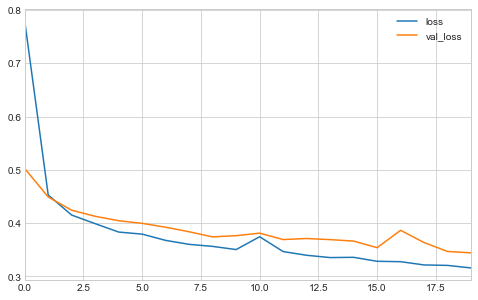

In [30]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.show()

In [31]:
model.evaluate(X_test, y_test, verbose=0)

0.32532836919607117

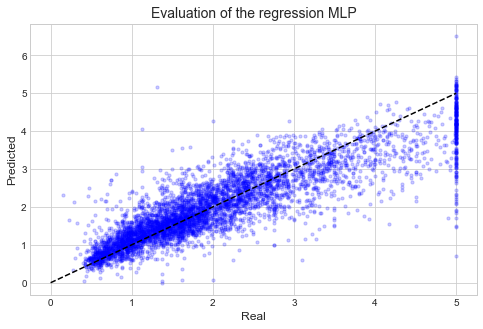

In [32]:
y_pred = model.predict(X_test)
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, color='b', s=10, alpha=0.2)
plt.plot(np.linspace(0, 5, 10), np.linspace(0, 5, 10), 'k--')
plt.title('Evaluation of the regression MLP', fontsize=14)
plt.xlabel('Real', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
plt.show()

### Building complex models using the functional API

As an example of a more complex ANN topology, we will build a *Wide & Deep* neural network.
This is where some or all of the input layers connect directly to the output layer.
This allows the ANN to learn both simple and deep rules.
This architecture is built below using Keras's *functional API*.

In [33]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation='relu')(input_)
hidden2 = keras.layers.Dense(100, activation='relu')(hidden1)
concat = keras.layers.Concatenate()([input_, hidden2])
output = keras.layers.Dense(1, activation='relu')(concat)
model = keras.Model(inputs=[input_], outputs=[output])

Here is a line-by-line explanation:

1. First, an `Input` object is created with the shape and data type specified.
2. A dense layer with 30 neurons was created and connected to the input layer by passing it as input to a function.
3. A dense layer with 30 neurons was created and connected to the first hidden layer.
4. A `Concatenate` layer concatenated the input and second hidden layer.
5. An output layer was made and given the concatenate layer.
6. Finally, a Keras `Model` was created and given the input and output layers.

This strings together the layers to make a network.
A layer is connected to another by passing one as the input to a function call of the other.

Next, everything is the same as before.

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 2s 156us/sample - loss: 0.7767 - val_loss: 0.4869
Epoch 2/20
11610/11610 [==============================] - 1s 86us/sample - loss: 0.4573 - val_loss: 0.4619
Epoch 3/20
11610/11610 [==============================] - 1s 95us/sample - loss: 0.4768 - val_loss: 0.4714
Epoch 4/20
11610/11610 [==============================] - 1s 105us/sample - loss: 0.4138 - val_loss: 0.4226
Epoch 5/20
11610/11610 [==============================] - 1s 98us/sample - loss: 0.3877 - val_loss: 0.4010
Epoch 6/20
11610/11610 [==============================] - 1s 114us/sample - loss: 0.3811 - val_loss: 0.3984
Epoch 7/20
11610/11610 [==============================] - 2s 168us/sample - loss: 0.3746 - val_loss: 0.4009
Epoch 8/20
11610/11610 [==============================] - 2s 168us/sample - loss: 0.3716 - val_loss: 0.3903
Epoch 9/20
11610/11610 [==============================] - 1s 127us/sample - loss: 0.3674 -

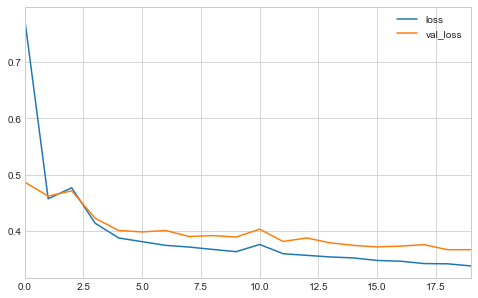

In [34]:
model.compile(loss='mean_squared_error', optimizer='sgd')

history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_valid, y_valid))

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.show()

In [35]:
model.evaluate(X_test, y_test, verbose=0)

0.35652519011682315

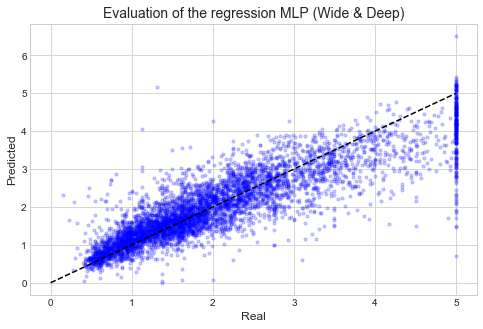

In [36]:
y_pred_new = model.predict(X_test)
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, color='b', s=10, alpha=0.2)
plt.plot(np.linspace(0, 5, 10), np.linspace(0, 5, 10), 'k--')
plt.title('Evaluation of the regression MLP (Wide & Deep)', fontsize=14)
plt.xlabel('Real', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
plt.show()

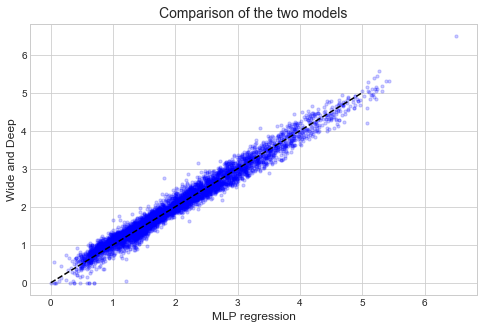

In [37]:
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, y_pred_new, color='b', s=10, alpha=0.2)
plt.plot(np.linspace(0, 5, 10), np.linspace(0, 5, 10), 'k--')
plt.title('Comparison of the two models', fontsize=14)
plt.xlabel('MLP regression', fontsize=12)
plt.ylabel('Wide and Deep', fontsize=12)
plt.show()

It is also possible to have multiple inputs.
This can be useful if you only want some inputs to go through the hidden layers.
Below is an example where features 0 through 4 go through the wide path and 2 through 7 go through the hidden layers.

In [38]:
# Two input layers.
input_A = keras.layers.Input(shape=[5], name='wide_input')
input_B = keras.layers.Input(shape=[6], name='deep_input')

# Hidden layers.
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(100, activation='relu')(hidden1)

# Concatenate.
concat = keras.layers.concatenate([input_A, hidden2])

# Output.
output = keras.layers.Dense(1, name='output')(concat)

# Make the model object.
model = keras.Model(inputs=[input_A, input_B], outputs=[output])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 100)          3100        dense_6[0][0]                    
____________________________________________________________________________________________

Compiling the model is the same as before.

In [39]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))

To fit the model, we must pass two matrices, one per input.
Alternatively, a dictionary with keys of the input layer names and values of the input matrices can be passed.

In [40]:
def split_input_matrices(A):
    return A[:, :5], A[:, 2:]


history = model.fit(split_input_matrices(X_train),
                    y_train,
                    epochs=20,
                    validation_data=(split_input_matrices(X_valid), y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 2s 151us/sample - loss: 2.1714 - val_loss: 0.9608
Epoch 2/20
11610/11610 [==============================] - 1s 95us/sample - loss: 0.7916 - val_loss: 0.7177
Epoch 3/20
11610/11610 [==============================] - 1s 100us/sample - loss: 0.6790 - val_loss: 0.6621
Epoch 4/20
11610/11610 [==============================] - 1s 95us/sample - loss: 0.6309 - val_loss: 0.6262
Epoch 5/20
11610/11610 [==============================] - 1s 95us/sample - loss: 0.5986 - val_loss: 0.5993
Epoch 6/20
11610/11610 [==============================] - 1s 95us/sample - loss: 0.5740 - val_loss: 0.5806
Epoch 7/20
11610/11610 [==============================] - 1s 94us/sample - loss: 0.5541 - val_loss: 0.5651
Epoch 8/20
11610/11610 [==============================] - 1s 95us/sample - loss: 0.5379 - val_loss: 0.5440
Epoch 9/20
11610/11610 [==============================] - 1s 94us/sample - loss: 0.5250 - val

In [41]:
model.evaluate(split_input_matrices(X_test), y_test, verbose=0)

0.4853714690189953

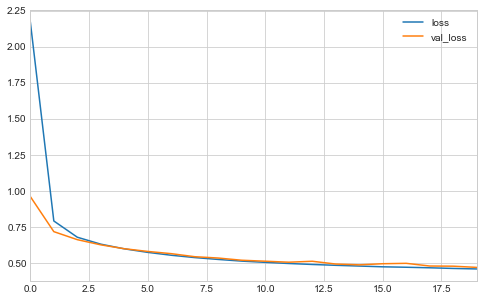

In [42]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.show()

Adding outputs is just as easy in adding inputs.
The following code is the same structure as the *Wide & Deep* ANN except there is an additional output from the second hidden layer.

In [43]:
# Two input layers.
input_A = keras.layers.Input(shape=[5], name='wide_input')
input_B = keras.layers.Input(shape=[6], name='deep_input')

# Hidden layers.
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(100, activation='relu')(hidden1)

# Concatenate.
concat = keras.layers.concatenate([input_A, hidden2])

# Output.
output = keras.layers.Dense(1, name='output')(concat)
aux_output = keras.layers.Dense(1, name='aux_output')(hidden2)

# Make the model object.
model = keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 100)          3100        dense_8[0][0]                    
____________________________________________________________________________________________

Each output requires a loss function and we can weight the loss scores by which we value more.
These are stated at the compile step.

In [44]:
model.compile(loss=['mse', 'mse'],
              loss_weights=[0.9, 0.1],
              optimizer='sgd')

For fitting, each output also needs a set of labels.

In [45]:
history = model.fit(split_input_matrices(X_train), 
                    (y_train, y_train),
                    epochs=20,
                    validation_data=(
                        split_input_matrices(X_valid), 
                        (y_valid, y_valid)
                    ))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 2s 210us/sample - loss: 1.0211 - output_loss: 0.9023 - aux_output_loss: 2.0904 - val_loss: 0.5812 - val_output_loss: 0.5272 - val_aux_output_loss: 1.0675
Epoch 2/20
11610/11610 [==============================] - 1s 112us/sample - loss: 0.5320 - output_loss: 0.4827 - aux_output_loss: 0.9762 - val_loss: 0.5017 - val_output_loss: 0.4623 - val_aux_output_loss: 0.8570
Epoch 3/20
11610/11610 [==============================] - 1s 110us/sample - loss: 0.4772 - output_loss: 0.4409 - aux_output_loss: 0.8032 - val_loss: 0.4799 - val_output_loss: 0.4500 - val_aux_output_loss: 0.7493
Epoch 4/20
11610/11610 [==============================] - 1s 110us/sample - loss: 0.4675 - output_loss: 0.4403 - aux_output_loss: 0.7140 - val_loss: 0.4518 - val_output_loss: 0.4264 - val_aux_output_loss: 0.6814
Epoch 5/20
11610/11610 [==============================] - 1s 111us/sample - loss: 0.4396 - output_loss:

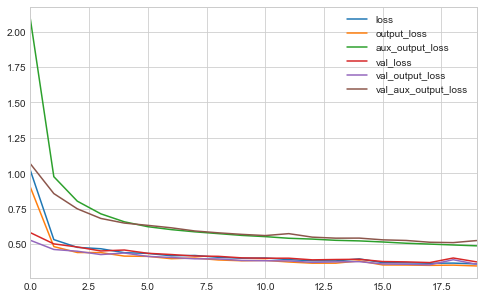

In [46]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.show()

In [47]:
X_new = split_input_matrices(X_test)
y_new, y_new_aux = model.predict(X_new)

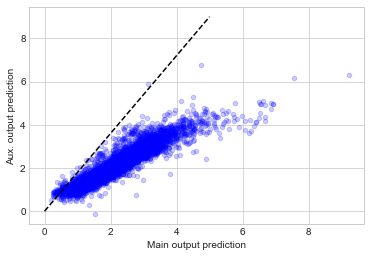

In [48]:
plt.scatter(y_new, y_new_aux, c='b', s=20, alpha=0.2)
plt.plot(np.linspace(0, 5, 10), np.linspace(0, 9, 10), 'k--')
plt.xlabel('Main output prediction')
plt.ylabel('Aux. output prediction')
plt.show()

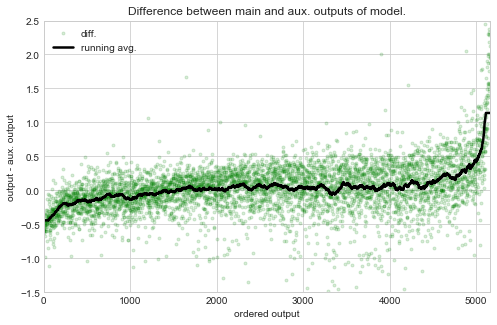

In [49]:
from sklearn.neighbors import KNeighborsRegressor
y_order = np.argsort(y_new.ravel())
y_diff = y_new[y_order] - y_new_aux[y_order]
x = np.arange(len(y_diff)).reshape(-1, 1)

knn = KNeighborsRegressor(n_neighbors=100)
y_knn = knn.fit(x, y_diff).predict(x)

plt.figure(figsize=(8, 5))
plt.plot(x, y_diff, 'g.', alpha=0.15, label='diff.')
plt.plot(x, y_knn, 'k-', linewidth=2.5, label='running avg.')
plt.axis((0, np.max(x), -1.5, 2.5))
plt.xlabel('ordered output')
plt.ylabel('output - aux. output')
plt.title('Difference between main and aux. outputs of model.')
plt.legend(loc='best')
plt.show()

### Using the subclassing API to build dynamic models

The Sequential and Functional APIs are declariative and, thus, have a static model graph.
This has many advantages because TF can display and analyze the graph.
However, this means it has limited flebibility.

The Subclassing API adds limitless flexibility.
The main steps are to subclass the `Model` class, create the layers in the constructor, and use them to perform any computations in the `call()` method.
The `call()` method can do anything the programming likes, including using for-loops or logical branching.

Below is an implementation of the *Wide & Deep* model from above using the Subclassing API.

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 2s 211us/sample - loss: 0.9067 - output_1_loss: 0.7862 - output_2_loss: 1.9906 - val_loss: 0.6329 - val_output_1_loss: 0.5529 - val_output_2_loss: 1.3543
Epoch 2/20
11610/11610 [==============================] - 1s 106us/sample - loss: 0.6313 - output_1_loss: 0.5556 - output_2_loss: 1.3108 - val_loss: 0.5660 - val_output_1_loss: 0.4984 - val_output_2_loss: 1.1756
Epoch 3/20
11610/11610 [==============================] - 2s 133us/sample - loss: 0.5602 - output_1_loss: 0.4951 - output_2_loss: 1.1465 - val_loss: 0.5236 - val_output_1_loss: 0.4713 - val_output_2_loss: 0.9946
Epoch 4/20
11610/11610 [==============================] - 2s 135us/sample - loss: 0.5182 - output_1_loss: 0.4662 - output_2_loss: 0.9852 - val_loss: 0.4949 - val_output_1_loss: 0.4528 - val_output_2_loss: 0.8743
Epoch 5/20
11610/11610 [==============================] - 1s 129us/sample - loss: 0.4791 - output_1_los

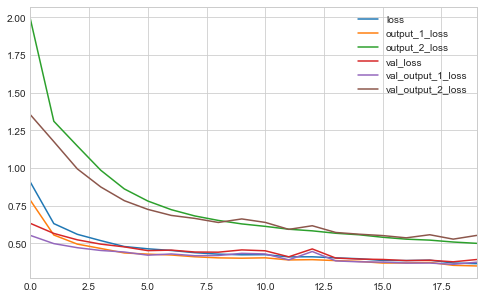

In [50]:
class WideAndDeep(keras.Model):
    """
    The 'Wide & Deep' ANN using the subclassing Keras API.
    """

    def __init__(self, units=30, activation='relu', **kwargs):
        super().__init__(**kwargs)  # handles standard argumentas such as `name`
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aut_output = keras.layers.Dense(1)

    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aut_output(hidden2)
        return main_output, aux_output


# Create the model object, compile, and fit.
model = WideAndDeep()
model.compile(loss=['mse', 'mse'],
              loss_weights=[0.9, 0.1],
              optimizer='sgd')

history = model.fit(split_input_matrices(X_train),
                    (y_train, y_train),
                    epochs=20,
                    validation_data=(
                        split_input_matrices(X_valid),
                        (y_valid, y_valid)
))

# Plot the progress of the training.
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.show()

In general, it is safer and easier to use the Sequential and Functional Keras APIs.

### Saving and Restoring a Model

Saving a model created using the Sequential or Functional APIs is simple and shown below.

In [51]:
# ** An example model built using the functional API ** #
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation='relu')(input_)
hidden2 = keras.layers.Dense(100, activation='relu')(hidden1)
concat = keras.layers.Concatenate()([input_, hidden2])
output = keras.layers.Dense(1, activation='relu')(concat)
model = keras.Model(inputs=[input_], outputs=[output])

model.compile(loss='mean_squared_error', optimizer='sgd')

history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_valid, y_valid))

model.summary()

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 2s 171us/sample - loss: 0.8478 - val_loss: 0.4696
Epoch 2/20
11610/11610 [==============================] - 1s 96us/sample - loss: 0.4339 - val_loss: 0.4445
Epoch 3/20
11610/11610 [==============================] - 1s 96us/sample - loss: 0.4091 - val_loss: 0.4279
Epoch 4/20
11610/11610 [==============================] - 1s 96us/sample - loss: 0.4000 - val_loss: 0.4103
Epoch 5/20
11610/11610 [==============================] - 1s 96us/sample - loss: 0.3953 - val_loss: 0.4073
Epoch 6/20
11610/11610 [==============================] - 1s 97us/sample - loss: 0.3847 - val_loss: 0.4041
Epoch 7/20
11610/11610 [==============================] - 1s 97us/sample - loss: 0.3765 - val_loss: 0.3991
Epoch 8/20
11610/11610 [==============================] - 1s 96us/sample - loss: 0.3720 - val_loss: 0.3991
Epoch 9/20
11610/11610 [==============================] - 1s 96us/sample - loss: 0.3826 - val_

In [52]:
import pathlib

# Save the model.
assets_path = pathlib.Path('assets/ch10')
model.save(assets_path.joinpath('my_keras_model.h5'))

Then, the model can be loaded using the `load()` method.

In [53]:
model = keras.models.load_model(assets_path.joinpath('my_keras_model.h5'))

The process is not very easy if the model was built with the Subclassing API.
The programmer would have to save and load the model parameters with `save_weights()` and `load_weights()` explcitly, and then recreate the model manually.

### Using Callbacks

The `fit()` method accepts a `callback` argument that is a list of `callback` objects that get called during each round (the point at which they get called can be specified, too).
They are useful for when a model may take a long time to train and you want to save intermediates such that they can be re-loaded if the computer crashes midway.
Another useful case is to set `save_bast_only=True` for a `ModelCheckpoint` callback object to that only the best model on the validation data is saved.
This can help prevent overfitting by essentially implementing early-stopping.

In [54]:
# Create the model.
model = keras.Model(inputs=[input_], outputs=[output])

# Compile the model.
model.compile(loss='mean_squared_error', optimizer='sgd')

# Add a checkpoint to save the model on each round of training.
# The model is only saved if it improves upon the previous on the
#   validation data set.
checkpoint_path = assets_path.joinpath('my_keras_model_chkpt.h5')
checkpoint_cb = keras.callbacks.ModelCheckpoint(checkpoint_path.as_posix(),
                                                save_best_only=True)

# Fit the model.
history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 2s 162us/sample - loss: 0.3388 - val_loss: 0.3708
Epoch 2/20
11610/11610 [==============================] - 1s 102us/sample - loss: 0.3364 - val_loss: 0.3672
Epoch 3/20
11610/11610 [==============================] - 1s 102us/sample - loss: 0.3345 - val_loss: 0.3708
Epoch 4/20
11610/11610 [==============================] - 1s 102us/sample - loss: 0.3321 - val_loss: 0.3617
Epoch 5/20
11610/11610 [==============================] - 1s 101us/sample - loss: 0.3291 - val_loss: 0.3620
Epoch 6/20
11610/11610 [==============================] - 1s 109us/sample - loss: 0.3280 - val_loss: 0.3672
Epoch 7/20
11610/11610 [==============================] - 1s 107us/sample - loss: 0.3258 - val_loss: 0.3624
Epoch 8/20
11610/11610 [==============================] - 1s 102us/sample - loss: 0.3254 - val_loss: 0.3632
Epoch 9/20
11610/11610 [==============================] - 1s 103us/sample - loss: 0.322

Alternatively, the `EarlyStopping` callback can be used.
A common implementation is to use both `ModelCheckpoint` and `EarlyStopping` together, the first to save intermediate models in case of a crash, the latter to prevent unnecessary time spent on training.
The number of epochs can also be increased because early-stopping will prevent overfitting and excessive training..

In [55]:
# Two input layers.
input_A = keras.layers.Input(shape=[5], name='wide_input')
input_B = keras.layers.Input(shape=[6], name='deep_input')

# Hidden layers.
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(100, activation='relu')(hidden1)

# Concatenate.
concat = keras.layers.concatenate([input_A, hidden2])

# Output.
output = keras.layers.Dense(1, name='output')(concat)
aux_output = keras.layers.Dense(1, name='aux_output')(hidden2)

# Make the model object.
model = keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])


# Add a checkpoint to save the model on each round of training.
# The model is only saved if it improves upon the previous on the
#   validation data set.
checkpoint_path = assets_path.joinpath('my_keras_model_chkpt.h5')
checkpoint_cb = keras.callbacks.ModelCheckpoint(checkpoint_path.as_posix(),
                                                save_best_only=True)

# Implement easly stopping after no improvement for 5 epochs.
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)

model.compile(loss=['mse', 'mse'],
              loss_weights=[0.9, 0.1],
              optimizer='sgd')

history = model.fit(split_input_matrices(X_train),
                    (y_train, y_train),
                    epochs=100,
                    validation_data=(
                        split_input_matrices(X_valid),
                        (y_valid, y_valid)
                    ),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 3s 238us/sample - loss: 1.0470 - output_loss: 0.9302 - aux_output_loss: 2.0948 - val_loss: 0.6145 - val_output_loss: 0.5463 - val_aux_output_loss: 1.2302
Epoch 2/100
11610/11610 [==============================] - 1s 125us/sample - loss: 0.6306 - output_loss: 0.5695 - aux_output_loss: 1.1828 - val_loss: 0.5389 - val_output_loss: 0.4841 - val_aux_output_loss: 1.0337
Epoch 3/100
11610/11610 [==============================] - 1s 120us/sample - loss: 0.5229 - output_loss: 0.4710 - aux_output_loss: 0.9895 - val_loss: 0.4987 - val_output_loss: 0.4552 - val_aux_output_loss: 0.8904
Epoch 4/100
11610/11610 [==============================] - 1s 120us/sample - loss: 0.4771 - output_loss: 0.4362 - aux_output_loss: 0.8451 - val_loss: 0.4718 - val_output_loss: 0.4372 - val_aux_output_loss: 0.7841
Epoch 5/100
11610/11610 [==============================] - 2s 167us/sample - loss: 0.4556 - output_

11610/11610 [==============================] - 1s 103us/sample - loss: 0.3266 - output_loss: 0.3175 - aux_output_loss: 0.4072 - val_loss: 0.3415 - val_output_loss: 0.3315 - val_aux_output_loss: 0.4317
Epoch 40/100
11610/11610 [==============================] - 1s 95us/sample - loss: 0.3289 - output_loss: 0.3204 - aux_output_loss: 0.4053 - val_loss: 0.3386 - val_output_loss: 0.3283 - val_aux_output_loss: 0.4319
Epoch 41/100
11610/11610 [==============================] - 1s 97us/sample - loss: 0.3251 - output_loss: 0.3165 - aux_output_loss: 0.4031 - val_loss: 0.3461 - val_output_loss: 0.3352 - val_aux_output_loss: 0.4443
Epoch 42/100
11610/11610 [==============================] - 1s 102us/sample - loss: 0.3288 - output_loss: 0.3206 - aux_output_loss: 0.4033 - val_loss: 0.3443 - val_output_loss: 0.3343 - val_aux_output_loss: 0.4354
Epoch 43/100
11610/11610 [==============================] - 1s 92us/sample - loss: 0.3245 - output_loss: 0.3161 - aux_output_loss: 0.3996 - val_loss: 0.3355 - 

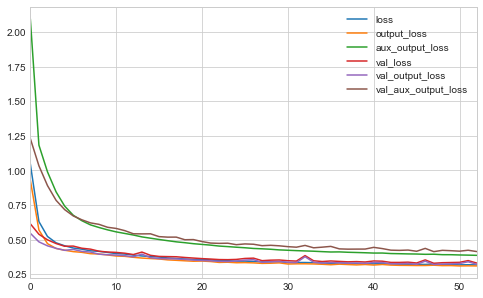

In [56]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.show()

It is also possible to implement custom callbacks by subclassing `Callback` and defining methods with names such as `on_epoch_begin()`, `on_train_begin()`, and more.
Below is an example that logs the validation over training error on each epoch to detect overfitting.

In [57]:
class PrintValidationTrainingRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print(f'\nval/train: {logs["val_loss"] / logs["loss"]}')

### Using Tensorboard for Visualization

Tensorboard is a powerful visualization tool for Tensorflow models.
To run it, we must save special binary log files called *event files* to a subdirectory in a root log folder.
It is best to save each record (called a *summary*) to s unique subdirectory so it can be inspected in the future.

Below is a function that creates a new subdirectory based on the date and time.

In [58]:
from pathlib import Path
root_logdir = Path('tf_logs_ch10')

# Remove old examples.
!rm -rf $root_logdir/*

def get_run_logdir():
    import time
    run_id = time.strftime('run_%Y_%m_%d_%H_%M_%S')
    return root_logdir.joinpath(run_id).as_posix()

In [59]:
get_run_logdir()

'tf_logs_ch10/run_2020_01_04_17_20_42'

Below, I train and run two ANNs on the blobs artificial data set.

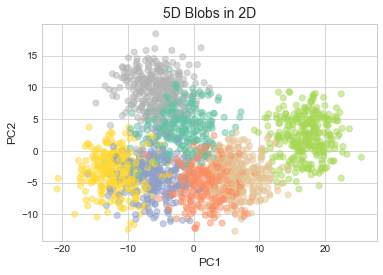

In [60]:
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

X_blob, y_blob = make_blobs(n_samples=2000,
                            n_features=5,
                            centers=7,
                            cluster_std=3,
                            random_state=0)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        shuffle=True,
                                                                        random_state=0)

pca = PCA(n_components=2)
blob_reduced = pca.fit_transform(X_blob)

plt.scatter(blob_reduced[:, 0], blob_reduced[:, 1],
            c=y_blob, cmap='Set2', alpha=0.5)
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.title('5D Blobs in 2D', fontsize=14)
plt.show()

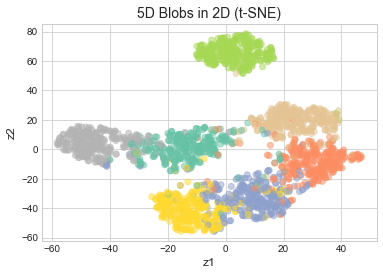

In [61]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=0)
blob_reduced = tsne.fit_transform(X_blob)

plt.scatter(blob_reduced[:, 0], blob_reduced[:, 1],
            c=y_blob, cmap='Set2', alpha=0.5)
plt.xlabel('z1', fontsize=12)
plt.ylabel('z2', fontsize=12)
plt.title('5D Blobs in 2D (t-SNE)', fontsize=14)
plt.show()

In [62]:
# Construct.
ann_1 = keras.models.Sequential([
    keras.layers.Input(shape=X_blob.shape[1]),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(7, activation='softmax')
])

# Compile.
ann_1.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

# Callback for Tensorboard.
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir())

# Train.
history = ann_1.fit(X_blob_train, 
          y_blob_train, 
          epochs=30, 
          validation_split=0.2, 
          callbacks=[tensorboard_cb])

Train on 1200 samples, validate on 300 samples
Epoch 1/30
1200/1200 [==============================] - 1s 609us/sample - loss: 0.9922 - accuracy: 0.7092 - val_loss: 0.5765 - val_accuracy: 0.8200
Epoch 2/30
1200/1200 [==============================] - 0s 131us/sample - loss: 0.4867 - accuracy: 0.8567 - val_loss: 0.4400 - val_accuracy: 0.8700
Epoch 3/30
1200/1200 [==============================] - 0s 126us/sample - loss: 0.4094 - accuracy: 0.8667 - val_loss: 0.3908 - val_accuracy: 0.8867
Epoch 4/30
1200/1200 [==============================] - 0s 127us/sample - loss: 0.3753 - accuracy: 0.8742 - val_loss: 0.3650 - val_accuracy: 0.8800
Epoch 5/30
1200/1200 [==============================] - 0s 126us/sample - loss: 0.3569 - accuracy: 0.8800 - val_loss: 0.3574 - val_accuracy: 0.8900
Epoch 6/30
1200/1200 [==============================] - 0s 125us/sample - loss: 0.3408 - accuracy: 0.8917 - val_loss: 0.3475 - val_accuracy: 0.8833
Epoch 7/30
1200/1200 [==============================] - 0s 122us/

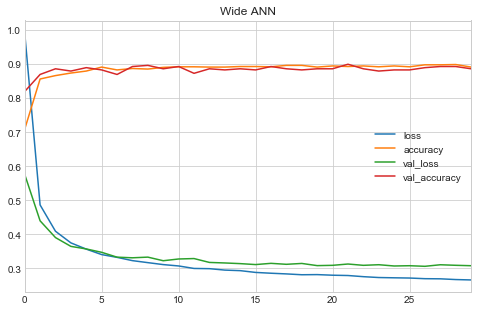

In [63]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.title('Wide ANN')
plt.show()

In [64]:
# Construct.
ann_2 = keras.models.Sequential([
    keras.layers.Input(shape=X_blob.shape[1]),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(7, activation='softmax')
])

# Compile.
ann_2.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

# Callback for Tensorboard.
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir())

# Train.
history = ann_2.fit(X_blob_train, 
          y_blob_train, 
          epochs=30, 
          validation_split=0.2, 
          callbacks=[tensorboard_cb])

Train on 1200 samples, validate on 300 samples
Epoch 1/30
1200/1200 [==============================] - 1s 898us/sample - loss: 1.8715 - accuracy: 0.2492 - val_loss: 1.5670 - val_accuracy: 0.3733
Epoch 2/30
1200/1200 [==============================] - 0s 141us/sample - loss: 1.4984 - accuracy: 0.4492 - val_loss: 1.3758 - val_accuracy: 0.5233
Epoch 3/30
1200/1200 [==============================] - 0s 136us/sample - loss: 1.3493 - accuracy: 0.5350 - val_loss: 1.2634 - val_accuracy: 0.5800
Epoch 4/30
1200/1200 [==============================] - 0s 136us/sample - loss: 1.2427 - accuracy: 0.5900 - val_loss: 1.1741 - val_accuracy: 0.5933
Epoch 5/30
1200/1200 [==============================] - 0s 135us/sample - loss: 1.1400 - accuracy: 0.6225 - val_loss: 1.0824 - val_accuracy: 0.6433
Epoch 6/30
1200/1200 [==============================] - 0s 142us/sample - loss: 1.0364 - accuracy: 0.6667 - val_loss: 0.9943 - val_accuracy: 0.6833
Epoch 7/30
1200/1200 [==============================] - 0s 135us/

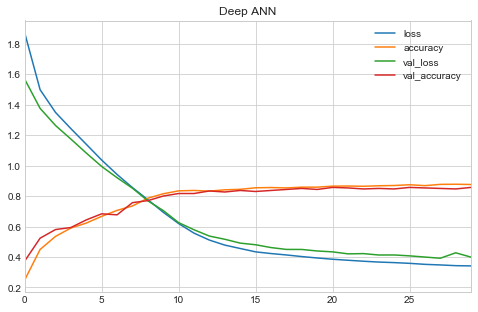

In [65]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.title('Deep ANN')
plt.show()

Tensorboard can be started either from the CLI or through magic commands in a Jupyter Notebook.
The latter is used to activate Tesnorboard below.
For the CLI method, just use the second command without the leading `%`.

In [66]:
%reload_ext tensorboard
%tensorboard --logdir=./tf_logs_ch10 --port=6006

## Fine-tuning neural network hyperparameters

The simplest, yet naive, way of tuning the hyperparamters is to use Grid Search or Randomized Search from Chapter 2.
To use the `GridSearchCV` and `RandomizedSearchCV` classes from Scikit-Learn, we need to make one function to construct and compile the ANN, then wrap it with a Scikit-Learn API using `keras.wrappers.scikit_learn.KerasRegressor` or `KerasClassifier`.

Below is an example of creating a regressor to predict the values for a very high-dimensional linear model.

In [67]:
from sklearn.datasets import make_regression

Xr, yr = make_regression(n_samples=4000,
                         n_features=100,
                         n_informative=90,
                         n_targets=1,
                         bias=0.0,
                         noise=20,
                         shuffle=True,
                         coef=False,
                         random_state=0)

Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, 
                                                        random_state=0, 
                                                        shuffle=True)

The first step if to create a single function that constructs and compiles the ANN given a set of the hyperparamters to tune.
Only the hyperparamters made available as arguments can be tuned.

In [68]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-4, input_shape=100):
    """Construct and compile a Keras Sequential ANN."""
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for i in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation='relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    return model

The second step it to wrap this function with the Scikit-Learn API.

In [69]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

Below is how an example if how to train a single model using the wrapped regression ANN.
For now, it has all of the default hyperparamters.

In [70]:

history = keras_reg.fit(Xr_train,
                        yr_train,
                        epochs=100,
                        validation_split=0.2,
                        callbacks=[keras.callbacks.EarlyStopping(patience=5)],
                        verbose=1)

Train on 2400 samples, validate on 600 samples
Epoch 1/100
2400/2400 [==============================] - 2s 697us/sample - loss: 80842.7652 - val_loss: 5614.9643
Epoch 2/100
2400/2400 [==============================] - 0s 171us/sample - loss: 3843.9761 - val_loss: 2835.9806
Epoch 3/100
2400/2400 [==============================] - 0s 90us/sample - loss: 1603.5196 - val_loss: 1486.6631
Epoch 4/100
2400/2400 [==============================] - 0s 124us/sample - loss: 910.3000 - val_loss: 1020.2191
Epoch 5/100
2400/2400 [==============================] - 0s 112us/sample - loss: 655.0098 - val_loss: 1012.5459
Epoch 6/100
2400/2400 [==============================] - 0s 88us/sample - loss: 555.6573 - val_loss: 919.6081
Epoch 7/100
2400/2400 [==============================] - ETA: 0s - loss: 477.036 - 0s 106us/sample - loss: 483.7755 - val_loss: 922.0758
Epoch 8/100
2400/2400 [==============================] - 0s 145us/sample - loss: 458.3321 - val_loss: 864.5639
Epoch 9/100
2400/2400 [=========

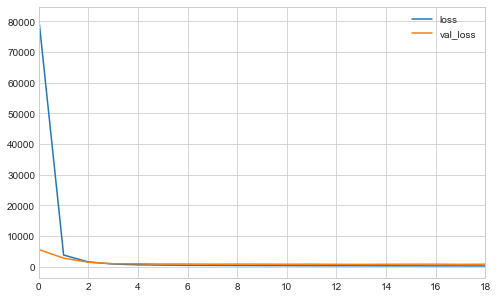

In [71]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.show()

Finally, below is an small example of using Randomized Search with 3-fold CV to tune three of the models hyperparamters.

In [72]:
%%capture

from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    'n_hidden': [0, 1, 2, 3],
    'n_neurons': np.arange(1, 100),
    'learning_rate': reciprocal(3e-6, 3e-3)
}

# Wrap the Keras regressor and set the number of input neurons.
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

# Create the randomized search object and train.
rnd_search_cv = RandomizedSearchCV(keras_reg,
                                   param_distributions=param_distribs,
                                   n_iter=5,
                                   cv=2,
                                   verbose=0)
rnd_search_cv.fit(Xr_train, yr_train,
                  epochs=100,
                  validation_split=0.2,
                  callbacks=[keras.callbacks.EarlyStopping(patience=5)],
                  verbose=0)

In [73]:
rnd_search_cv.best_params_

{'learning_rate': 1.876245776062917e-05, 'n_hidden': 3, 'n_neurons': 15}